In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [8]:
#torch.manual_seed(7)

In [9]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_75564/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_75564/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [10]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_75564/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_75564/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [11]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [12]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 130.45it/s]


Epoch 0/100, Loss: 0.21839846670627594, train dataset accuracy: 90.99666666666667
test dataset accuracy: 96.53%


100%|██████████| 235/235 [00:01<00:00, 183.34it/s]


Epoch 1/100, Loss: 0.033807992935180664, train dataset accuracy: 96.6
test dataset accuracy: 95.71%


100%|██████████| 235/235 [00:01<00:00, 200.23it/s]


Epoch 2/100, Loss: 0.17627911269664764, train dataset accuracy: 97.38333333333334
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:01<00:00, 195.89it/s]


Epoch 3/100, Loss: 0.05551277473568916, train dataset accuracy: 97.83
test dataset accuracy: 97.08%


100%|██████████| 235/235 [00:01<00:00, 208.67it/s]


Epoch 4/100, Loss: 0.08958947658538818, train dataset accuracy: 98.10833333333333
test dataset accuracy: 97.54%


100%|██████████| 235/235 [00:01<00:00, 179.92it/s]


Epoch 5/100, Loss: 0.010630457662045956, train dataset accuracy: 98.395
test dataset accuracy: 97.06%


100%|██████████| 235/235 [00:01<00:00, 154.50it/s]


Epoch 6/100, Loss: 0.009406696073710918, train dataset accuracy: 98.34166666666667
test dataset accuracy: 97.44%


100%|██████████| 235/235 [00:01<00:00, 187.96it/s]


Epoch 7/100, Loss: 0.0994412824511528, train dataset accuracy: 98.56333333333333
test dataset accuracy: 97.4%


100%|██████████| 235/235 [00:01<00:00, 195.57it/s]


Epoch 8/100, Loss: 0.09319910407066345, train dataset accuracy: 98.59166666666667
test dataset accuracy: 97.43%


100%|██████████| 235/235 [00:01<00:00, 190.41it/s]


Epoch 9/100, Loss: 0.06276720017194748, train dataset accuracy: 98.63666666666667
test dataset accuracy: 97.38%


100%|██████████| 235/235 [00:01<00:00, 199.98it/s]


Epoch 10/100, Loss: 0.12741097807884216, train dataset accuracy: 98.83333333333333
test dataset accuracy: 97.53%


100%|██████████| 235/235 [00:01<00:00, 125.86it/s]


Epoch 11/100, Loss: 0.029810713604092598, train dataset accuracy: 98.945
test dataset accuracy: 97.76%


100%|██████████| 235/235 [00:01<00:00, 166.56it/s]


Epoch 12/100, Loss: 0.02284269966185093, train dataset accuracy: 99.01
test dataset accuracy: 97.67%


100%|██████████| 235/235 [00:01<00:00, 194.79it/s]


Epoch 13/100, Loss: 0.12327101826667786, train dataset accuracy: 99.05666666666667
test dataset accuracy: 97.13%


100%|██████████| 235/235 [00:01<00:00, 181.43it/s]


Epoch 14/100, Loss: 0.016422532498836517, train dataset accuracy: 99.02
test dataset accuracy: 97.74%


100%|██████████| 235/235 [00:01<00:00, 169.58it/s]


Epoch 15/100, Loss: 0.060101062059402466, train dataset accuracy: 99.12
test dataset accuracy: 97.52%


100%|██████████| 235/235 [00:01<00:00, 178.49it/s]


Epoch 16/100, Loss: 0.016202809289097786, train dataset accuracy: 99.025
test dataset accuracy: 97.34%


100%|██████████| 235/235 [00:01<00:00, 172.27it/s]


Epoch 17/100, Loss: 0.04716569557785988, train dataset accuracy: 98.94833333333334
test dataset accuracy: 97.01%


100%|██████████| 235/235 [00:01<00:00, 141.65it/s]


Epoch 18/100, Loss: 0.0009892432717606425, train dataset accuracy: 99.07
test dataset accuracy: 97.52%


100%|██████████| 235/235 [00:01<00:00, 189.38it/s]


Epoch 19/100, Loss: 0.06698119640350342, train dataset accuracy: 99.26166666666667
test dataset accuracy: 97.89%


100%|██████████| 235/235 [00:01<00:00, 187.99it/s]


Epoch 20/100, Loss: 0.010200503282248974, train dataset accuracy: 99.43833333333333
test dataset accuracy: 97.7%


100%|██████████| 235/235 [00:01<00:00, 156.11it/s]


Epoch 21/100, Loss: 0.16282613575458527, train dataset accuracy: 99.20333333333333
test dataset accuracy: 97.69%


100%|██████████| 235/235 [00:01<00:00, 193.81it/s]


Epoch 22/100, Loss: 0.0036708165425807238, train dataset accuracy: 99.29166666666667
test dataset accuracy: 97.8%


100%|██████████| 235/235 [00:01<00:00, 171.70it/s]


Epoch 23/100, Loss: 0.014596633613109589, train dataset accuracy: 99.35333333333334
test dataset accuracy: 97.62%


100%|██████████| 235/235 [00:01<00:00, 139.07it/s]


Epoch 24/100, Loss: 0.015755770727992058, train dataset accuracy: 99.30333333333333
test dataset accuracy: 97.87%


100%|██████████| 235/235 [00:01<00:00, 133.77it/s]


Epoch 25/100, Loss: 0.08358868956565857, train dataset accuracy: 99.38666666666667
test dataset accuracy: 97.29%


100%|██████████| 235/235 [00:01<00:00, 131.75it/s]


Epoch 26/100, Loss: 0.0772104486823082, train dataset accuracy: 99.35
test dataset accuracy: 97.69%


100%|██████████| 235/235 [00:01<00:00, 178.51it/s]


Epoch 27/100, Loss: 0.004652475472539663, train dataset accuracy: 99.25333333333333
test dataset accuracy: 97.77%


100%|██████████| 235/235 [00:01<00:00, 155.62it/s]


Epoch 28/100, Loss: 0.01723594404757023, train dataset accuracy: 99.32833333333333
test dataset accuracy: 97.03%


100%|██████████| 235/235 [00:01<00:00, 132.62it/s]


Epoch 29/100, Loss: 0.03193704038858414, train dataset accuracy: 99.48333333333333
test dataset accuracy: 97.72%


100%|██████████| 235/235 [00:01<00:00, 123.74it/s]


Epoch 30/100, Loss: 0.005603402387350798, train dataset accuracy: 99.46833333333333
test dataset accuracy: 97.41%


100%|██████████| 235/235 [00:01<00:00, 175.06it/s]


Epoch 31/100, Loss: 0.05501933768391609, train dataset accuracy: 99.55166666666666
test dataset accuracy: 97.8%


100%|██████████| 235/235 [00:01<00:00, 193.54it/s]


Epoch 32/100, Loss: 0.003154419595375657, train dataset accuracy: 99.44333333333333
test dataset accuracy: 97.72%


100%|██████████| 235/235 [00:01<00:00, 199.81it/s]


Epoch 33/100, Loss: 0.11157602816820145, train dataset accuracy: 99.45833333333333
test dataset accuracy: 97.7%


100%|██████████| 235/235 [00:01<00:00, 206.97it/s]


Epoch 34/100, Loss: 4.394177722133463e-06, train dataset accuracy: 99.50666666666666
test dataset accuracy: 97.7%


100%|██████████| 235/235 [00:01<00:00, 136.73it/s]


Epoch 35/100, Loss: 0.02319628931581974, train dataset accuracy: 99.46666666666667
test dataset accuracy: 97.72%


100%|██████████| 235/235 [00:01<00:00, 192.44it/s]


Epoch 36/100, Loss: 0.03292625769972801, train dataset accuracy: 99.44
test dataset accuracy: 97.73%


100%|██████████| 235/235 [00:01<00:00, 135.67it/s]


Epoch 37/100, Loss: 0.0002569829812273383, train dataset accuracy: 99.59666666666666
test dataset accuracy: 97.67%


100%|██████████| 235/235 [00:01<00:00, 191.33it/s]


Epoch 38/100, Loss: 0.0017428179271519184, train dataset accuracy: 99.47166666666666
test dataset accuracy: 97.86%


100%|██████████| 235/235 [00:01<00:00, 138.15it/s]


Epoch 39/100, Loss: 0.0015038610436022282, train dataset accuracy: 99.6
test dataset accuracy: 97.92%


100%|██████████| 235/235 [00:01<00:00, 137.95it/s]


Epoch 40/100, Loss: 0.01831875927746296, train dataset accuracy: 99.61666666666666
test dataset accuracy: 97.84%


100%|██████████| 235/235 [00:01<00:00, 187.56it/s]


Epoch 41/100, Loss: 1.954413346538786e-05, train dataset accuracy: 99.5
test dataset accuracy: 97.73%


100%|██████████| 235/235 [00:01<00:00, 130.52it/s]


Epoch 42/100, Loss: 0.02571764402091503, train dataset accuracy: 99.59666666666666
test dataset accuracy: 97.64%


100%|██████████| 235/235 [00:01<00:00, 183.52it/s]


Epoch 43/100, Loss: 0.015863800421357155, train dataset accuracy: 99.56166666666667
test dataset accuracy: 97.66%


100%|██████████| 235/235 [00:01<00:00, 129.21it/s]


Epoch 44/100, Loss: 0.01759239286184311, train dataset accuracy: 99.26833333333333
test dataset accuracy: 97.64%


100%|██████████| 235/235 [00:01<00:00, 181.66it/s]


Epoch 45/100, Loss: 0.01113493274897337, train dataset accuracy: 99.49333333333334
test dataset accuracy: 97.85%


100%|██████████| 235/235 [00:01<00:00, 194.87it/s]


Epoch 46/100, Loss: 0.2145722508430481, train dataset accuracy: 99.67166666666667
test dataset accuracy: 97.95%


100%|██████████| 235/235 [00:01<00:00, 196.93it/s]


Epoch 47/100, Loss: 0.00021865991584490985, train dataset accuracy: 99.59666666666666
test dataset accuracy: 97.8%


100%|██████████| 235/235 [00:01<00:00, 198.53it/s]


Epoch 48/100, Loss: 0.0011290438706055284, train dataset accuracy: 99.39166666666667
test dataset accuracy: 97.26%


100%|██████████| 235/235 [00:01<00:00, 164.93it/s]


Epoch 49/100, Loss: 0.1659218817949295, train dataset accuracy: 99.33333333333333
test dataset accuracy: 97.68%


100%|██████████| 235/235 [00:01<00:00, 174.99it/s]


Epoch 50/100, Loss: 0.00017102334822993726, train dataset accuracy: 99.585
test dataset accuracy: 97.54%


100%|██████████| 235/235 [00:01<00:00, 182.94it/s]


Epoch 51/100, Loss: 0.023414621129631996, train dataset accuracy: 99.66666666666667
test dataset accuracy: 98.12%


100%|██████████| 235/235 [00:01<00:00, 163.41it/s]


Epoch 52/100, Loss: 0.04319068416953087, train dataset accuracy: 99.80666666666667
test dataset accuracy: 97.91%


100%|██████████| 235/235 [00:01<00:00, 148.40it/s]


Epoch 53/100, Loss: 0.02819417603313923, train dataset accuracy: 99.59166666666667
test dataset accuracy: 97.64%


100%|██████████| 235/235 [00:01<00:00, 193.38it/s]


Epoch 54/100, Loss: 0.025899497792124748, train dataset accuracy: 99.59666666666666
test dataset accuracy: 97.66%


100%|██████████| 235/235 [00:01<00:00, 128.45it/s]


Epoch 55/100, Loss: 0.005365620832890272, train dataset accuracy: 99.49666666666667
test dataset accuracy: 97.81%


100%|██████████| 235/235 [00:01<00:00, 168.57it/s]


Epoch 56/100, Loss: 0.0022832814138382673, train dataset accuracy: 99.59833333333333
test dataset accuracy: 98.02%


100%|██████████| 235/235 [00:01<00:00, 196.88it/s]


Epoch 57/100, Loss: 0.0012526720529422164, train dataset accuracy: 99.69
test dataset accuracy: 97.75%


100%|██████████| 235/235 [00:01<00:00, 190.12it/s]


Epoch 58/100, Loss: 0.0023596712853759527, train dataset accuracy: 99.725
test dataset accuracy: 97.9%


100%|██████████| 235/235 [00:01<00:00, 136.12it/s]


Epoch 59/100, Loss: 0.020694900304079056, train dataset accuracy: 99.70666666666666
test dataset accuracy: 97.64%


100%|██████████| 235/235 [00:01<00:00, 189.06it/s]


Epoch 60/100, Loss: 0.0033228464890271425, train dataset accuracy: 99.55666666666667
test dataset accuracy: 97.88%


100%|██████████| 235/235 [00:01<00:00, 165.60it/s]


Epoch 61/100, Loss: 0.018132494762539864, train dataset accuracy: 99.545
test dataset accuracy: 97.61%


100%|██████████| 235/235 [00:01<00:00, 183.58it/s]


Epoch 62/100, Loss: 0.0008628973155282438, train dataset accuracy: 99.62333333333333
test dataset accuracy: 97.81%


100%|██████████| 235/235 [00:01<00:00, 186.42it/s]


Epoch 63/100, Loss: 0.024767672643065453, train dataset accuracy: 99.74166666666666
test dataset accuracy: 97.92%


100%|██████████| 235/235 [00:02<00:00, 109.56it/s]


Epoch 64/100, Loss: 4.020478809252381e-05, train dataset accuracy: 99.79166666666667
test dataset accuracy: 97.76%


100%|██████████| 235/235 [00:01<00:00, 147.77it/s]


Epoch 65/100, Loss: 0.018480587750673294, train dataset accuracy: 99.71333333333334
test dataset accuracy: 97.63%


100%|██████████| 235/235 [00:02<00:00, 108.81it/s]


Epoch 66/100, Loss: 0.05510907247662544, train dataset accuracy: 99.64
test dataset accuracy: 97.63%


100%|██████████| 235/235 [00:01<00:00, 120.28it/s]


Epoch 67/100, Loss: 0.014096613973379135, train dataset accuracy: 99.51
test dataset accuracy: 97.62%


100%|██████████| 235/235 [00:01<00:00, 130.19it/s]


Epoch 68/100, Loss: 0.0003553501737769693, train dataset accuracy: 99.52666666666667
test dataset accuracy: 97.29%


100%|██████████| 235/235 [00:01<00:00, 173.44it/s]


Epoch 69/100, Loss: 0.0025637533981353045, train dataset accuracy: 99.64333333333333
test dataset accuracy: 97.56%


100%|██████████| 235/235 [00:00<00:00, 239.10it/s]


Epoch 70/100, Loss: 4.940627604810288e-06, train dataset accuracy: 99.49833333333333
test dataset accuracy: 97.6%


100%|██████████| 235/235 [00:01<00:00, 231.75it/s]


Epoch 71/100, Loss: 4.7253313823603094e-05, train dataset accuracy: 99.77666666666667
test dataset accuracy: 97.94%


100%|██████████| 235/235 [00:01<00:00, 206.59it/s]


Epoch 72/100, Loss: 0.02606954611837864, train dataset accuracy: 99.73833333333333
test dataset accuracy: 97.87%


100%|██████████| 235/235 [00:01<00:00, 159.61it/s]


Epoch 73/100, Loss: 0.0008925558067858219, train dataset accuracy: 99.73333333333333
test dataset accuracy: 97.77%


100%|██████████| 235/235 [00:01<00:00, 209.59it/s]


Epoch 74/100, Loss: 0.0002481478441040963, train dataset accuracy: 99.825
test dataset accuracy: 97.9%


100%|██████████| 235/235 [00:01<00:00, 212.05it/s]


Epoch 75/100, Loss: 0.0055718072690069675, train dataset accuracy: 99.75
test dataset accuracy: 97.88%


100%|██████████| 235/235 [00:00<00:00, 251.22it/s]


Epoch 76/100, Loss: 0.10362555831670761, train dataset accuracy: 99.625
test dataset accuracy: 97.09%


100%|██████████| 235/235 [00:00<00:00, 250.18it/s]


Epoch 77/100, Loss: 0.14307630062103271, train dataset accuracy: 99.49333333333334
test dataset accuracy: 97.69%


100%|██████████| 235/235 [00:00<00:00, 244.34it/s]


Epoch 78/100, Loss: 0.0013899352634325624, train dataset accuracy: 99.37833333333333
test dataset accuracy: 97.06%


100%|██████████| 235/235 [00:01<00:00, 136.67it/s]


Epoch 79/100, Loss: 0.000101728510344401, train dataset accuracy: 99.555
test dataset accuracy: 97.75%


100%|██████████| 235/235 [00:01<00:00, 234.90it/s]


Epoch 80/100, Loss: 0.08835026621818542, train dataset accuracy: 99.64666666666666
test dataset accuracy: 97.61%


100%|██████████| 235/235 [00:00<00:00, 249.65it/s]


Epoch 81/100, Loss: 0.00036644827923737466, train dataset accuracy: 99.67833333333333
test dataset accuracy: 97.81%


100%|██████████| 235/235 [00:00<00:00, 251.28it/s]


Epoch 82/100, Loss: 0.0007034647278487682, train dataset accuracy: 99.745
test dataset accuracy: 97.75%


100%|██████████| 235/235 [00:00<00:00, 239.54it/s]


Epoch 83/100, Loss: 0.053237613290548325, train dataset accuracy: 99.62666666666667
test dataset accuracy: 97.13%


100%|██████████| 235/235 [00:01<00:00, 159.09it/s]


Epoch 84/100, Loss: 0.0001071108563337475, train dataset accuracy: 99.63166666666666
test dataset accuracy: 97.58%


100%|██████████| 235/235 [00:01<00:00, 152.41it/s]


Epoch 85/100, Loss: 0.0006784326396882534, train dataset accuracy: 99.75166666666667
test dataset accuracy: 97.76%


100%|██████████| 235/235 [00:01<00:00, 206.18it/s]


Epoch 86/100, Loss: 6.494306035165209e-07, train dataset accuracy: 99.74166666666666
test dataset accuracy: 97.77%


100%|██████████| 235/235 [00:01<00:00, 139.64it/s]


Epoch 87/100, Loss: 0.0014608897035941482, train dataset accuracy: 99.755
test dataset accuracy: 97.71%


100%|██████████| 235/235 [00:01<00:00, 120.42it/s]


Epoch 88/100, Loss: 0.03446384519338608, train dataset accuracy: 99.525
test dataset accuracy: 97.68%


100%|██████████| 235/235 [00:02<00:00, 116.66it/s]


Epoch 89/100, Loss: 2.4806990040815435e-05, train dataset accuracy: 99.47666666666667
test dataset accuracy: 97.76%


100%|██████████| 235/235 [00:01<00:00, 134.08it/s]


Epoch 90/100, Loss: 0.0003647523990366608, train dataset accuracy: 99.66166666666666
test dataset accuracy: 97.74%


100%|██████████| 235/235 [00:01<00:00, 187.54it/s]


Epoch 91/100, Loss: 0.023151854053139687, train dataset accuracy: 99.86833333333334
test dataset accuracy: 97.91%


100%|██████████| 235/235 [00:01<00:00, 184.51it/s]


Epoch 92/100, Loss: 1.986820130639444e-08, train dataset accuracy: 99.84666666666666
test dataset accuracy: 97.91%


100%|██████████| 235/235 [00:01<00:00, 145.86it/s]


Epoch 93/100, Loss: 0.08791244029998779, train dataset accuracy: 99.445
test dataset accuracy: 97.23%


100%|██████████| 235/235 [00:01<00:00, 182.15it/s]


Epoch 94/100, Loss: 0.00258769397623837, train dataset accuracy: 99.61833333333334
test dataset accuracy: 97.81%


100%|██████████| 235/235 [00:01<00:00, 216.18it/s]


Epoch 95/100, Loss: 2.9650464057340287e-05, train dataset accuracy: 99.745
test dataset accuracy: 97.73%


100%|██████████| 235/235 [00:01<00:00, 148.22it/s]


Epoch 96/100, Loss: 0.04459309205412865, train dataset accuracy: 99.81833333333333
test dataset accuracy: 97.64%


100%|██████████| 235/235 [00:01<00:00, 141.20it/s]


Epoch 97/100, Loss: 0.02871405892074108, train dataset accuracy: 99.54166666666667
test dataset accuracy: 97.59%


100%|██████████| 235/235 [00:01<00:00, 198.06it/s]


Epoch 98/100, Loss: 0.2837214171886444, train dataset accuracy: 99.70666666666666
test dataset accuracy: 97.68%


100%|██████████| 235/235 [00:00<00:00, 249.46it/s]

Epoch 99/100, Loss: 0.006390366703271866, train dataset accuracy: 99.40333333333334
test dataset accuracy: 97.5%


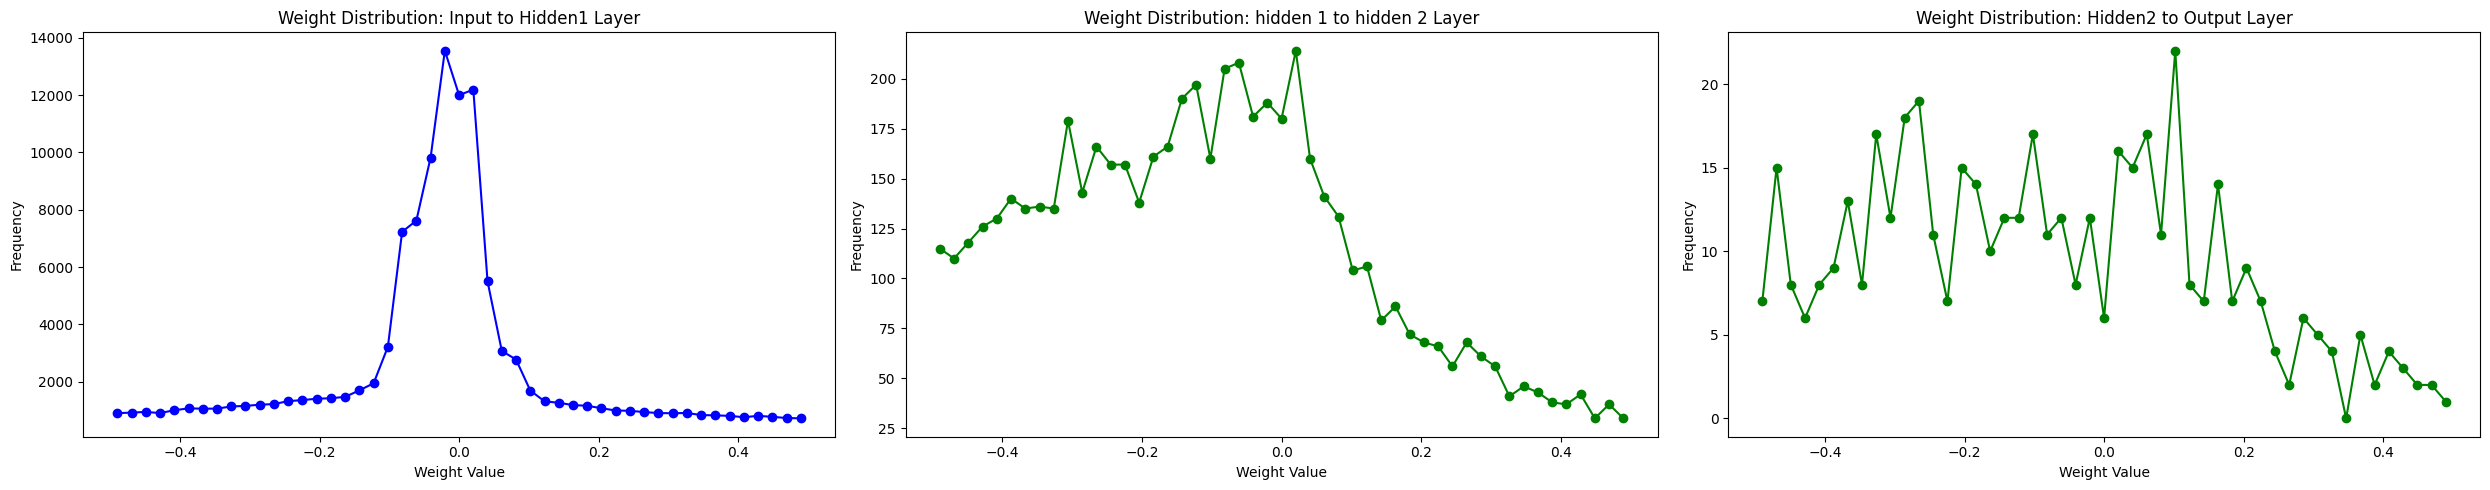

In [13]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [14]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 188947
Number of non-zero weights greater than 0.01 in layer 1: 8016
Number of non-zero weights greater than 0.01 in layer 3: 634


In [15]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.3203068643301609, 0.32316104087188263, 0.3957539662550515, 0.3328976536723188, 0.31656333966774086, 0.3060963634762617, 0.370406705668097, 0.3289895285944779, 0.3543276136362697, 0.33426062279939445, 0.334553466258179, 0.31036771370378574, 0.34035087964941413, 0.3244189064772476, 0.37211110720656554, 0.34747016941190345, 0.6190400162075724, 0.31519623550309356, 0.31929939276439123, 0.297230312999316, 0.3146137602584113, 0.5552588480741424, 0.306998695511372, 0.3423161824699599, 0.342969497944832, 0.32178647340174604, 0.3312327051184254, 0.47821847149093183, 0.5306239214344252, 0.5158715556627713, 0.31915608602431855, 0.28341461430115145, 0.3520042572277079, 0.2852538188154647, 0.3174433980347524, 0.3316189874097235, 0.35320504270007785, 0.32486745720429233, 0.31892727418329747, 0.31328251502295684, 0.33211788448654217, 0.3399581467279725, 0.29388330365176973, 0.4117928965652148, 0.3486999472276317, 0.5045991129506241, 0.3578546955233791, 0.35766943812098645, 0.3333095449289814, 0.27

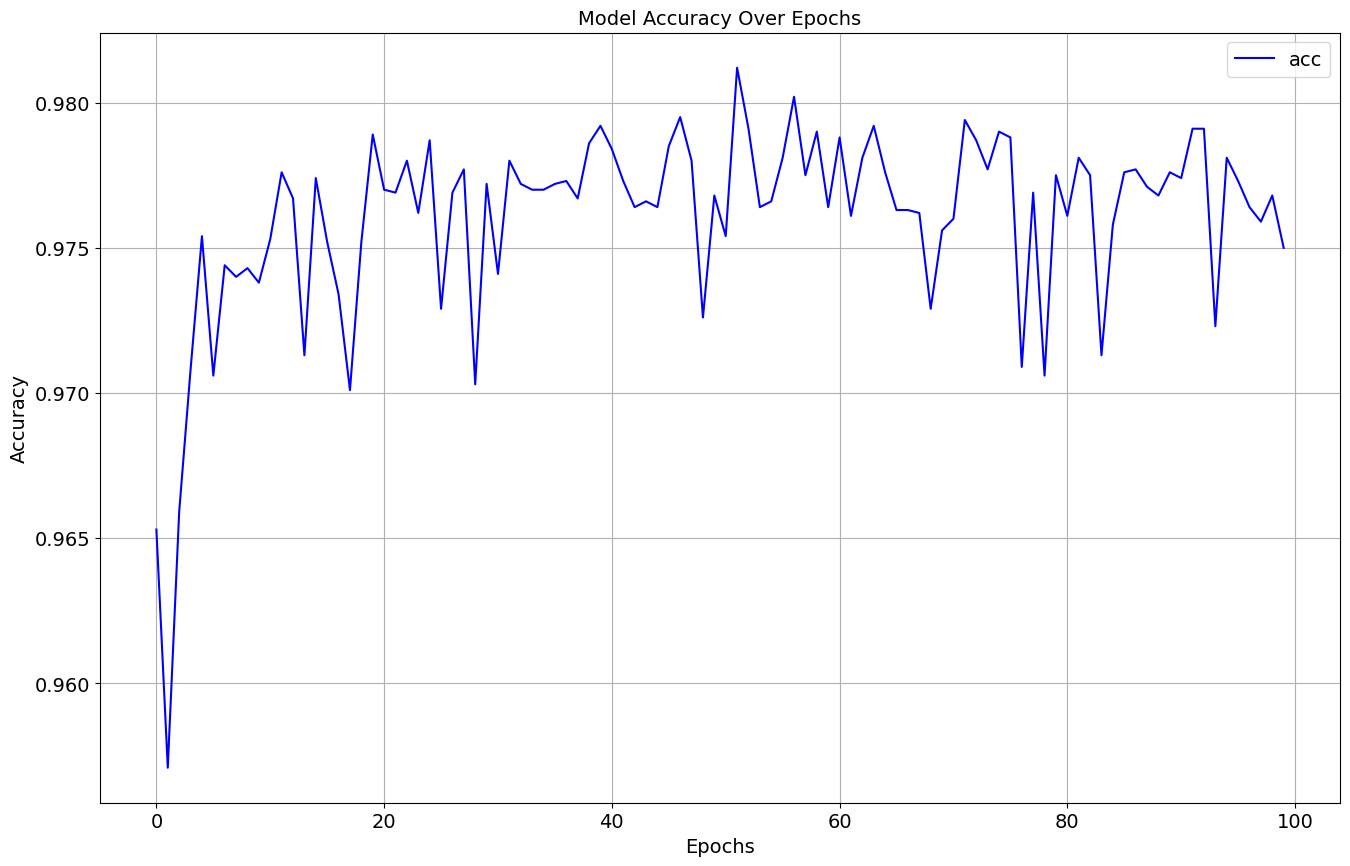

In [16]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [17]:
import pickle
with open('cleanAcc4.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'cleanAccModel4.pt')